In [56]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt

# Read from FRED

In [6]:
fred = Fred("6200247daa8548d813a5a6838a445171")

In [18]:
sp500 = fred.get_series("SP500", observation_start = "2010-01-01", observation_end = "2022-12-01")
sp500.name = "SP500"
sp500 = sp500.resample("MS").mean().copy()
sp500

2013-04-01    1570.702273
2013-05-01    1639.842727
2013-06-01    1618.772500
2013-07-01    1668.675455
2013-08-01    1670.093636
                 ...     
2022-08-01    4158.563043
2022-09-01    3850.520476
2022-10-01    3726.050952
2022-11-01    3917.488571
2022-12-01    4076.570000
Freq: MS, Name: SP500, Length: 117, dtype: float64

In [59]:
us_gdp = fred.get_series("GDP", observation_start = "2010-01-01", observation_end = "2022-12-01")
us_gdp.name = "US_GDP"
us_gdp.resample("MS").mean()

2010-01-01    14764.611
2010-02-01          NaN
2010-03-01          NaN
2010-04-01    14980.193
2010-05-01          NaN
                ...    
2022-06-01          NaN
2022-07-01    25723.941
2022-08-01          NaN
2022-09-01          NaN
2022-10-01    26137.992
Freq: MS, Name: US_GDP, Length: 154, dtype: float64

In [20]:
df0 = pd.concat([sp500, us_gdp], axis = 1, join = "inner")
df0 

,SP500,US_GDP
2013-04-01,1570.702273,16699.551
2013-07-01,1668.675455,16911.068
2013-10-01,1720.026522,17133.114
2014-01-01,1822.356667,17144.281
2014-04-01,1864.263333,17462.703
2014-07-01,1973.100000,17743.227
2014-10-01,1937.274348,17852.540
2015-01-01,2028.178500,17991.348
2015-04-01,2094.862857,18193.707
2015-07-01,2094.143636,18306.960


<AxesSubplot:>

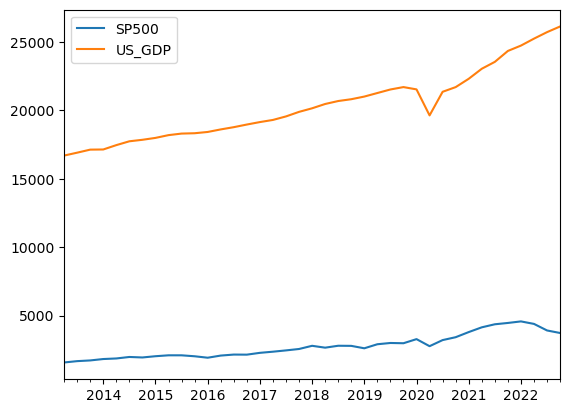

In [21]:
df0.plot()

# Testing ChatGPT's implementation

In [42]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import ccf

def prewhiten(x, y, x_model=AutoReg, ylab='CCF', **kwargs):
    
    def filter_mod(x, model):
        if len(model.params) >= 1:
            x = np.convolve(x, [1, -model.params], mode='same')
        elif len(model.k_ar) >= 1 and any(model.k_ar != 0):
            x = AutoReg(endog=x).filter(-model.k_ar, method='recursive')
        elif len(model.polynomial_ar) >= 1 and any(model.polynomial_ar != 0):
            x = np.array([x])  # wrap scalar in numpy array
            x = np.convolve(x, [1, -model.polynomial_ar], mode='same')
            x = x[0]  # unwrap array to scalar
        return x
    
    if x_model is not AutoReg:
        # x_model_fit = x_model(x, lags = ar_select_order(x, maxlag = 12, ic = "aic").ar_lags).fit(**kwargs)
        x_model_fit = x_model(x).fit(**kwargs)

        x = filter_mod(x, model=x_model_fit)
        y = filter_mod(y, model=x_model_fit)
    else:
        x_model_fit = x_model(x, lags = ar_select_order(x, maxlag = 12, ic = "aic").ar_lags).fit(**kwargs)
        x = np.convolve(x, [1, -x_model_fit.params], mode='same')
        y = np.convolve(y, [1, -x_model_fit.params], mode='same')
    ccf_xy = ccf(x, y, adjusted=True)
    return {'ccf': ccf_xy, 'model': x_model_fit}


In [52]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import ccf

def prewhiten(x, y, x_model=AutoReg, ylab='CCF', **kwargs):
    
    x = np.array(x).astype(float)
    y = np.array(y).astype(float)

    def filter_mod(x, model):
        if len(model.params) >= 1:
            x = np.convolve(x, [1, -model.params], mode='same')
        elif len(model.k_ar) >= 1 and any(model.k_ar != 0):
            x = AutoReg(endog=x).filter(-model.k_ar, method='recursive')
        elif len(model.polynomial_ar) >= 1 and any(model.polynomial_ar != 0):
            x = np.convolve(x, [1, -model.polynomial_ar], mode='same')
            x = np.array([x])  # wrap scalar in numpy array
            x = np.convolve(x, [1, -model.polynomial_ar], mode='same')
            x = x[0]  # unwrap array to scalar
            return x
    
    if x_model is not AutoReg:
        # x_model_fit = x_model(x, lags = ar_select_order(x, maxlag = 12, ic = "aic").ar_lags).fit(**kwargs)
        x_model_fit = x_model(x).fit(**kwargs)

        x = filter_mod(x, model=x_model_fit)
        y = filter_mod(y, model=x_model_fit)
    else:
        x_model_fit = x_model(x, lags = ar_select_order(x, maxlag = 12, ic = "aic").ar_lags).fit(**kwargs)
        x = np.convolve(x, [1, -x_model_fit.params], mode='same')
        y = np.convolve(y, [1, -x_model_fit.params], mode='same')
    
    ccf_xy = ccf(x, y, adjusted=True)
    return {'ccf': ccf_xy, 'model': x_model_fit}


<StemContainer object of 3 artists>

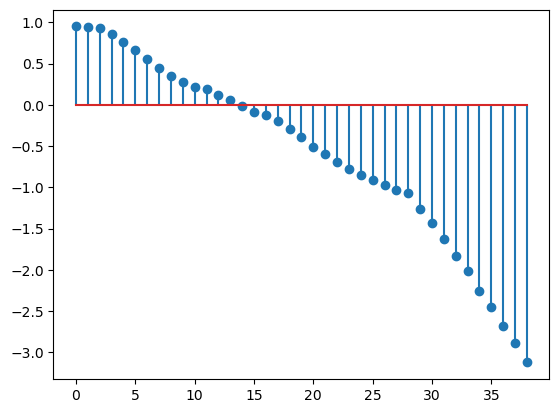

In [57]:
plt.stem(ccf(df0["US_GDP"].values, df0["SP500"].values))

In [51]:
df0["US_GDP"].values

array([16699.551, 16911.068, 17133.114, 17144.281, 17462.703, 17743.227,
       17852.54 , 17991.348, 18193.707, 18306.96 , 18332.079, 18425.306,
       18611.617, 18775.459, 18968.041, 19148.194, 19304.506, 19561.896,
       19894.75 , 20155.486, 20470.197, 20687.278, 20819.269, 21013.085,
       21272.448, 21531.839, 21706.532, 21538.032, 19636.731, 21362.428,
       21704.706, 22313.85 , 23046.934, 23550.42 , 24349.121, 24740.48 ,
       25248.476, 25723.941, 26137.992])